# Library

In [48]:
import pandas as pd
import numpy as np
import os
import random
import re
from tqdm import tqdm

#!pip install pecab
from pecab import PeCab
#!pip install keybert
from keybert import KeyBERT
#!pip install kiwipiepy
from kiwipiepy import Kiwi
from transformers import BertModel
!pip install konlpy
from konlpy.tag import Twitter


from wordcloud import WordCloud

import matplotlib.pyplot as plt
import seaborn as sns

#!pip install koreanize_matplotlib
import koreanize_matplotlib
%config InlineBackend.figure_format = 'retina'

# 경고 무시
import warnings
warnings.filterwarnings('ignore')

# 구글 드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 1.2 MB/s 
     |████████████████████████████████| 465 kB 48.5 MB/s 
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Load

In [4]:
data_path = "/content/drive/My Drive/musinsa"
data_list = os.listdir(data_path)
data_list

['부정(asc) 총합본.csv', '긍정(desc)_총합본.csv', 'pecab_라벨.csv']

In [11]:
desc = pd.read_csv(f'{data_path}/{data_list[0]}', index_col=0)
asc = pd.read_csv(f'{data_path}/{data_list[1]}', index_col=0)

print('---------------------------------낮은 순---------------------------------')
print(asc.shape)
display(asc.head())
print('---------------------------------높은 순---------------------------------')
print(desc.shape)
display(desc.head())

---------------------------------낮은 순---------------------------------
(158621, 8)


,상품,리뷰,평점,신체,닉네임,레벨,카테고리,상품_num
0,릴렉스 핏 크루 넥 반팔 티셔츠 [화이트],이제야 후기 남기네요 너무 맘에들어서 또사고싳어요,100%,"[<p class=""review-profile__body_information"">남...",베개피좋네,6,상의>반소매티셔츠(무신사스탠다드),996177
1,릴렉스 핏 크루 넥 반팔 티셔츠 [오렌지],생각보다 색깔이 진해서 오히려 좋은거 같아요 코디하기에도 좋고,100%,"[<p class=""review-profile__body_information"">남...",뉴비_c4639868,3,상의>반소매티셔츠(무신사스탠다드),996177
2,릴렉스 핏 크루 넥 반팔 티셔츠 [퍼플 그레이],재질도 짱짱해서 좋규 다른 색상도 구매 각 입니다!,100%,"[<p class=""review-profile__body_information"">남...",식초ㅎ,3,상의>반소매티셔츠(무신사스탠다드),996177
3,릴렉스 핏 크루 넥 반팔 티셔츠 [블랙],색감이무고 사이즈도 예쁘게 잘 맞습니다 감사함,100%,"[<p class=""review-profile__body_information"">남...",부러운부럽소,5,상의>반소매티셔츠(무신사스탠다드),996177
4,릴렉스 핏 크루 넥 반팔 티셔츠 [라임],탄탄한 재질 근데 좀 오버핏임 치수 잘 보고 사시고 색이 생각보다 옅음,100%,"[<p class=""review-profile__body_information"">남...",그런말은말아탕,5,상의>반소매티셔츠(무신사스탠다드),996177


---------------------------------높은 순---------------------------------
(69274, 8)


,상품,리뷰,평점,신체,닉네임,레벨,카테고리,상품_num
0,릴렉스 핏 크루 넥 반팔 티셔츠 [라이트 그레이],"문안하고 착용감이 편함, 블레이져 이너로 입을 수 있고 셋업으로 착용했을 시 파티룩...",20%,"[<p class=""review-profile__body_information"">남...",도코드,4,상의>반소매티셔츠(무신사스탠다드),996177
1,릴렉스 핏 크루 넥 반팔 티셔츠 [화이트],목이 늘어난 옷이 왔어요 옷 안에 이너로 입기는 좋아요,20%,"[<p class=""review-profile__body_information"">남...",뉴비_e35eb2c4,5,상의>반소매티셔츠(무신사스탠다드),996177
2,릴렉스 핏 크루 넥 반팔 티셔츠 [화이트],사이즈도 조금 크고 재질이 저는 조금 별로네요ㅜㅜ깔끔한 느낌은 아닌고같우,20%,[],cvklas,4,상의>반소매티셔츠(무신사스탠다드),996177
3,릴렉스 핏 크루 넥 반팔 티셔츠 [화이트],재구매했다가 실망하네요 얇아졌어요 목카라좋아서 구매했는데,20%,"[<p class=""review-profile__body_information"">남...",체무,3,상의>반소매티셔츠(무신사스탠다드),996177
4,릴렉스 핏 크루 넥 반팔 티셔츠 [화이트],가격은 오르고. 목부분 퀄리티는 더 떨어졌네요.목이 두툼하게 마감되서 인생 티셔츠 ...,20%,[],우장춘수박,3,상의>반소매티셔츠(무신사스탠다드),996177


# EDA & Preprocessing

### dataframe 정리

In [12]:
# concat
data = pd.concat([asc, desc], axis=0)
data.shape

(227895, 8)

In [13]:
# 필요 feature 추출
data = data[['리뷰', '평점']]
data.sample(5)

,리뷰,평점
18150,한파 대비용으로 구매했는데 따뜻하고 귀엽고 예뻐용,100%
1465,사이즈 작네요 실측이랑 다름 무탠은 슬랙스만살래,20%
2610,덩달아 팔 운동도 되요엄청 시원한 편은 아닌데 쓸만해요,60%
18983,여름내내 빨리 세탁해 놓아야했던 바집니다!너무 편하고 시원했는지 어딜가나 이바지만 ...,100%
18368,디자인은 이쁜데 주름이 되게 잘생기고 색바랜거같아요,100%


In [14]:
# 중복 제거
data = data.drop_duplicates()
data.shape

(105945, 2)

In [15]:
# 평점 column 
data['평점'] = data['평점'].map(lambda x : x[:-1])
data['평점'] = data['평점'].astype(int)
data.sample(5)

,리뷰,평점
6288,"예뻐요 ! 생각보다 자주 신게 되네요꼬ㅐ 불편함 ,, 편하진 않아요",100
9183,키가 큰 편이라 발등덮는 길이의 바지를 찾기 힘들었는데 이 바지는 길이가 길어서 너...,100
18326,상당히 맘에 듭니다. 엄청 싸게 너무 좋은 옷 겟했네요. 잘 입을게요. 겨울 무난히...,100
14105,실착 해보고 무신사에서 시켜서 딱 맞아요 저는 검은색보다 밝은색이 더 잘어울려서 오...,100
29298,발마칸이나 피쉬테일이 지겨울때나다른무드 연출할때 한번씩 꺼내입기 좋습니다.,100


### 평점 20 부정, 평점 100 긍정 라벨링

In [16]:
# 평점 100 긍정
data_pos = data[data['평점']==100]
data_pos.shape

(74420, 2)

In [17]:
# 평점 20 부정
data_neg = data[data['평점']==20]
data_neg.shape

(11531, 2)

In [19]:
# sampling 1000
data_pos1000 = data_pos.sample(n=1000)
data_neg1000 = data_neg.sample(n=1000)

data_pos1000.shape, data_neg1000.shape

((1000, 2), (1000, 2))

In [20]:
# concat
data2000 = pd.concat([data_pos1000, data_neg1000], axis=0)
data2000.shape

(2000, 2)

In [21]:
# Labeling
data2000['라벨'] = data2000['평점'].map(lambda x : '긍정' if (x==100) else '부정') 
data2000.sample(5)

,리뷰,평점,라벨
311,평생신어본 나이키양말중에 이렇게 질안좋은건 처음봄.옷같은거 사면 사은품으로 같이주는...,20,부정
1625,생각보다 색감이 고급스럽습니다.적당한 두께와 클래식한 핏.무탠다드만의 스테디로 자리...,100,긍정
5745,아이보리 색상 사고싶엇는데 구매해서 입어보니까 만족스럽네요,100,긍정
1634,살짝 무게감 있어서 촥 떨어지는 느낌이 예쁘고 뒤에 끈으로 조절이 가능하게 되어있어...,100,긍정
6898,세상세상 입어보고 집에있던 다른코트 다 가져다 팔았습니다 판돈으로 다른색상도 살까싶...,100,긍정


In [22]:
# 리뷰 라벨 columns 사용
data2000 = data2000[['리뷰', '라벨']]
data2000.sample(5)

,리뷰,라벨
6959,아주 질이 쓰렉이다 동묘에서 팔 것 같은 재질이요,부정
319,"그냥 집에서 나 입을수 있을 얇기,그냥 집에서 입을게요, 주머니도 없음",부정
824,엉덩이 부분이 좀 끼는 느낌은 있지만 전투용 으로는 잘 입고 있습니다. 포켓 디테일...,부정
11120,비니 느낌도 내고 스냅백 느낌도 낼 수 있는 너무 만족하는 모자에요 힙해집니다,긍정
8400,길이가 짧아서 28-29로 교환하려고 했는데 품절됐다고 교환 자체를 못하게 해놨네요...,부정


In [24]:
# reset_index
data2000 = data2000.reset_index(drop=True)
data2000.head()

,리뷰,라벨
0,엑스라지가 딱 좋네요 이너로 입기 딱 좋습니다. 배송 엄청 빨라요,긍정
1,통이 진짜 너무너무커요ㅋㅋ다리가말랐는데 좀웃긴거같아요 남자분이입는게이쁜것같아요,긍정
2,적당하고 조아요오프에서 예전에구입하고 하나더구입합니당재질도좋고 조아요,긍정
3,크기가 커서 수납 엄청 많이 할수있어서 너무 좋습니다,긍정
4,정사이즈으로 주문하고 받아보니 좀 커서 한단계 작은 사이즈로 교환하였습니다~그래도 ...,긍정


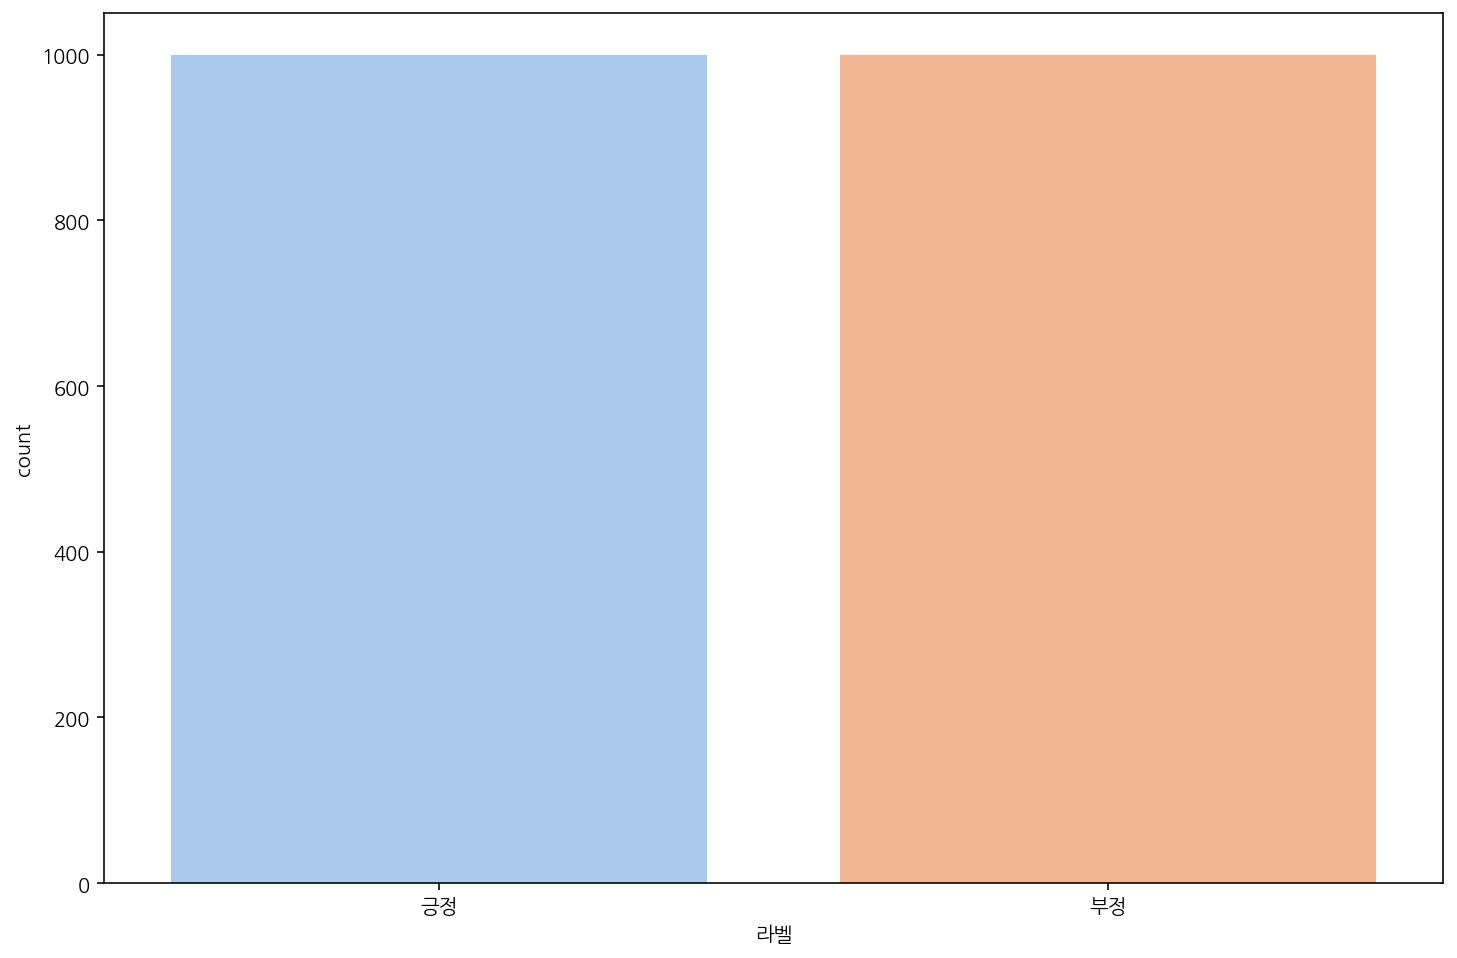

In [25]:
# 라벨 Visualization
_=sns.set_palette('pastel')
plt.figure(figsize=(12,8))
_=sns.countplot(data2000['라벨'])

### NLP 자연어 처리

In [26]:
def preprocessing(text):
    # 한글, 영문, 숫자만 남기고 모두 제거
    text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA]', " ", text)
    
    # 중복 생성된 공백값 제거
    text = re.sub('[\s]+', " ", text)
    
    # 영문자를 소문자로
    text = text.lower()
    
    return text

In [28]:
# 리뷰 문자 데이터 전처리
data2000['리뷰'] = data2000['리뷰'].map(preprocessing)
data2000['리뷰']

0                     엑스라지가 딱 좋네요 이너로 입기 딱 좋습니다 배송 엄청 빨라요
1             통이 진짜 너무너무커요ㅋㅋ다리가말랐는데 좀웃긴거같아요 남자분이입는게이쁜것같아요
2                  적당하고 조아요오프에서 예전에구입하고 하나더구입합니당재질도좋고 조아요
3                           크기가 커서 수납 엄청 많이 할수있어서 너무 좋습니다
4       정사이즈으로 주문하고 받아보니 좀 커서 한단계 작은 사이즈로 교환하였습니다 그래도 ...
                              ...                        
1995                   너무커요 이거 입으면 카디비엉덩이 가능합니다 비어있는 엉덩이 
1996    후 어디에 긁혀서 왔는지 스크래치 나있구요 어떻게보면 심하고 어떻게보면 아닌데 너무...
1997         카라 갈라지는 부분 목에 닿는 곳이 간지러워서 계속 긁게 됩니다 너무 불편하네요
1998    이거와 동일한 사이즈 스트레이트 크롭진 를 주문했습니다 크림진도 사이즈표의 사이즈보...
1999     월달에 사이즈를 최근에 사이즈를 샀습니다 사이즈는 사고 텍을 떼고 허리가 너무 조...
Name: 리뷰, Length: 2000, dtype: object

### 긍정/부정 각각 KeyBERT 적용

In [31]:
# 긍정 문자 추출
positive = data2000[data2000['라벨']=='긍정']
positive.sample(5)

,리뷰,라벨
918,생각보다 잘나와서 굉장히 만족하고 잘 입고있어요,긍정
267,실물 보고 기절할뻔했던 생화이트 진짜 미치게 예쁨 환해요 신발이 예쁜건 물론이고 발...,긍정
350,커플모자 샀는데 기대했던 핏은 아니에요 뭔가 모자가 모양이 잡혀있어서 딱 봤을때 엇...,긍정
389,색감이 너무 화려해 망설였는데 실물 귀엽네요사자 마자 블프 가격 할인 ㅜㅜ,긍정
270,덕캡이랑 같네요 캐쥬얼이나 정장에도 어울리거 같아요 활용범위 넓습니다,긍정


In [32]:
# 긍정 문장 keybery 적용
pos_keywords = []
model = BertModel.from_pretrained('skt/kobert-base-v1')
kw_model = KeyBERT(model)
for sentence in tqdm(positive['리뷰']):
    key_acc = kw_model.extract_keywords(sentence, keyphrase_ngram_range=(1, 1), stop_words=None, top_n=10)
    pos_keywords.append(key_acc)

print(pos_keywords[:5])

Downloading:   0%|          | 0.00/535 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/369M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/968 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.79k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/645 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/471M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/480 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/14.8M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

100%|██████████| 1000/1000 [02:38<00:00,  6.29it/s]

[[('좋네요', 0.894), ('이너로', 0.8843), ('빨라요', 0.8838), ('좋습니다', 0.8698), ('엄청', 0.7498), ('입기', 0.7199), ('엑스라지가', 0.7021), ('배송', 0.6121)], [('남자분이입는게이쁜것같아요', 0.869), ('좀웃긴거같아요', 0.8347), ('너무너무커요ㅋㅋ다리가말랐는데', 0.7578), ('진짜', 0.7467), ('통이', 0.7376)], [('하나더구입합니당재질도좋고', 0.9603), ('조아요오프에서', 0.8799), ('조아요', 0.8705), ('예전에구입하고', 0.8581), ('적당하고', 0.8479)], [('커서', 0.7225), ('크기가', 0.6797), ('엄청', 0.6686), ('많이', 0.6512), ('너무', 0.632), ('좋습니다', 0.576), ('할수있어서', 0.5704), ('수납', 0.5062)], [('될듯해요', 0.7804), ('막편하게', 0.7759), ('여유있네요', 0.773), ('귀여워요', 0.7664), ('정사이즈으로', 0.7646), ('사이즈로', 0.7625), ('적당하니', 0.7576), ('받아보니', 0.7562), ('작진않구', 0.756), ('그래도', 0.7412)]]


In [33]:
# 부정 문자 추출
negative = data2000[data2000['라벨']=='부정']
negative.sample(5)

,리뷰,라벨
1042,바지가 올때부터 허벅지 안쪽이랑 엉덩이랑 터져서 왔어요 근데 핏은 이쁨,부정
1716,저는 물건이 말도안되게 부실하면 리뷰를 다는데요겉보기엔 별 문제 없어보이는데 속은 ...,부정
1553,옷은 정말 맘에들어요평소사이즈 착용하지만 이제품은 도 잘맞아요코트 안에 레이어드 하...,부정
1288,너무하시네요 xxl구입해서 번입고 나갔는데 이건 아무리생각해도 작는거에요 너무 이상...,부정
1379,제가 혹시 중고제품을 구매한 건가요 일단 박스부터 다 뜯어져와서 중간에 물건 안 잃...,부정


In [34]:
# 부정 문장 keybery 적용
neg_keywords = []
model = BertModel.from_pretrained('skt/kobert-base-v1')
kw_model = KeyBERT(model)
for sentence in tqdm(negative['리뷰']):
    key_acc = kw_model.extract_keywords(sentence, keyphrase_ngram_range=(1, 1), stop_words=None, top_n=5)
    neg_keywords.append(key_acc)

print(neg_keywords[:5])

100%|██████████| 1000/1000 [04:03<00:00,  4.11it/s]

[[('가성비도좋고누빔안감이라따뜻하긴한데너무레자느낌이강해요', 1.0)], [('엄청풍기고바지재봉선쪽에', 0.5897), ('포장열자마자', 0.5782), ('화학냄새', 0.5106), ('꿰매서', 0.507), ('본드냄새같은', 0.4889)], [('실망스럽네요', 0.6721), ('구매하려고', 0.6533), ('구매한만큼', 0.6438), ('없어지지않네요모가', 0.5943), ('안전밸트자국이랑여기저기', 0.5782)], [('환불하기', 0.8171), ('신경써주세요', 0.8106), ('왔는데', 0.8005), ('입습니다', 0.7901), ('빵꾸있네요', 0.7858)], [('냄새', 0.7122), ('식초냄새가', 0.666), ('냄새가', 0.6536), ('세탁하면', 0.5871), ('세탁은', 0.581)]]


### 누적 단어 정리

In [40]:
# 긍정 누적 단어
pos_cum_count = []
for word in pos_keywords:
    for w in word:
      pos_cum_count.append(w[0])

pos_cum_count[:10]

['좋네요',
 '이너로',
 '빨라요',
 '좋습니다',
 '엄청',
 '입기',
 '엑스라지가',
 '배송',
 '남자분이입는게이쁜것같아요',
 '좀웃긴거같아요']

In [41]:
# 부정 누적 단어
neg_cum_count = []
for word in neg_keywords:
    for w in word:
      neg_cum_count.append(w[0])

neg_cum_count[:10]

['가성비도좋고누빔안감이라따뜻하긴한데너무레자느낌이강해요',
 '엄청풍기고바지재봉선쪽에',
 '포장열자마자',
 '화학냄새',
 '꿰매서',
 '본드냄새같은',
 '실망스럽네요',
 '구매하려고',
 '구매한만큼',
 '없어지지않네요모가']

In [43]:
# dataframe 
cum_count = pd.DataFrame([pos_cum_count, neg_cum_count]).T
cum_count.columns = ['긍정', '부정']
cum_count.head()

,긍정,부정
0,좋네요,가성비도좋고누빔안감이라따뜻하긴한데너무레자느낌이강해요
1,이너로,엄청풍기고바지재봉선쪽에
2,빨라요,포장열자마자
3,좋습니다,화학냄새
4,엄청,꿰매서


In [44]:
cum_count['긍정'].value_counts()

좋아요      145
너무       138
같아요       70
좋습니다      58
예뻐요       55
        ... 
별점         1
종이가        1
먹었습니다      1
부분에        1
잠바랑        1
Name: 긍정, Length: 4007, dtype: int64

In [46]:
cum_count['부정'].value_counts()

너무        52
그냥        38
샀는데       25
입고        23
상품        20
          ..
세탁힘드네요     1
흰옷은        1
까매짐        1
안입고있네요     1
사이즈랑       1
Name: 부정, Length: 3563, dtype: int64

#### 너무 의미없는 단어가 많아 Twitter를 이용하여 명사와 동사만 추출

In [52]:
# 긍정 품사
twt = Twitter()

tagging = []
for pos in tqdm(cum_count['긍정']):
    tagging.append(twt.pos(pos))
    
print(tagging[:5])

100%|██████████| 7906/7906 [00:05<00:00, 1400.51it/s]

[[('좋네요', 'Adjective')], [('이', 'Determiner'), ('너', 'Noun'), ('로', 'Josa')], [('빨라요', 'Adjective')], [('좋습니다', 'Adjective')], [('엄청', 'Adverb')]]


In [106]:
part = ['Adjective', 'Noun']
remove = ['좋아요', '좋네요', '좋고', '좋습니다', '너', '조아요', 
          '입니다', '때', '같아요', '맘', '정말', '너무']
real_pos = []
for tag in tagging:
    for t in tag:
       if t[1] in part:
          if t[0] not in remove:
              real_pos.append(t[0])

print(real_pos)

['빨라요', '엑스', '라지', '배송', '남자', '이쁜것', '좀', '다리', '말랐는데', '진짜', '통', '하나', '더', '구입', '재질', '오프', '예전', '구입', '적당하고', '커서', '크기', '수납', '해', '막', '편하게', '여유', '있네요', '귀여워요', '정사', '이즈', '로', '사이즈', '적당하니', '작진', '스타', '일링', '선명하고', '있어서', '확실히', '색', '스트링', '굿굿', '만족', '색감', '가격', '대비', '색상', '구입', '네이비', '색도', '무난', '챙', '외출', '용', '길지', '넓어', '보이', '두껍고', '만족스러운', '후드', '티', '어깨', '고다', '진짜', '여름', '가성', '비', '완전', '최고', '사서', '만족', '계속', '좋은', '가격', '있습니다', '아쉽습니다', '조금', '털', '사서', '아프고', '금', '발바닥', '아주', '예쁩니다', '해', '편한', '걸', '불편해서', '조금', '깔창', '항상', '기본', '하나', '좋아서', '삿어', '좋을듯', '회색', '사고', '검은색', '저렴하게', '데', '일리', '활용', '이쁘고', '좋음', '블프때', '제품', '할인', '십만원', '코트', '사면', '표면', '다른', '디자인', '사이즈', '예뻐요', '다양하게', '양면', '입을수있을거', '예뻐요', '구입', '구입', '마음', '컬러', '다른', '컬러', '귀여워요', '편하게', '좋구', '가격', '대비', '다만', '벗', '조금', '운동', '불편합니다', '운동', '예뻐서', '만족해요', '예쁘고', '있어요', '색깔', '가격', '대비', '해', '하나', '운동', '가방', '가방', '부담스러웠는데', '사이즈', '구매', '아들', '적당하고', '학원', '편하게', '가격', '무난

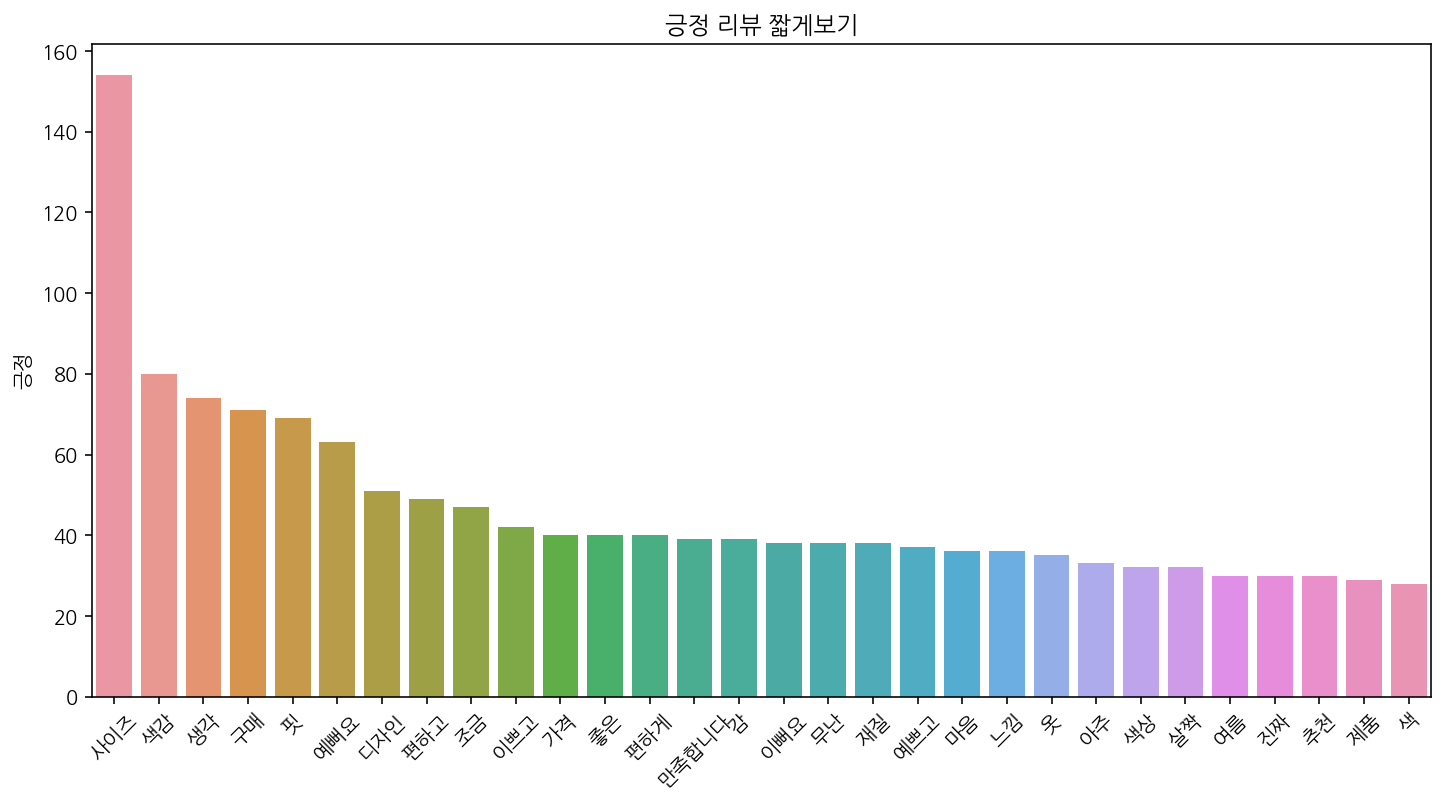

In [116]:
d = pd.DataFrame(real_pos)
d.columns = ['긍정']

pos_top30 = d['긍정'].value_counts().sort_values(ascending=False)[:30]
pos_top30 = pd.DataFrame(pos_top30)

plt.figure(figsize=(12,6))
_=sns.barplot(x=pos_top30.index, y=pos_top30['긍정'])
_=plt.xticks(rotation=45)
_=plt.title('긍정 리뷰 짧게보기')

In [109]:
# 부정 품사
twt = Twitter()

tagging = []
try :
    for pos in tqdm(cum_count['부정']):
        tagging.append(twt.pos(pos))

except AssertionError as e:
    pass
    
print(tagging[:5])

 63%|██████▎   | 4954/7906 [00:04<00:02, 1218.34it/s]

[[('가성', 'Noun'), ('비도', 'Noun'), ('좋', 'Adjective'), ('고누', 'Noun'), ('빔', 'Noun'), ('안감', 'Noun'), ('이라', 'Josa'), ('따뜻하긴한데', 'Adjective'), ('너무', 'Adverb'), ('레', 'Noun'), ('자', 'Suffix'), ('느낌', 'Noun'), ('이', 'Josa'), ('강해요', 'Adjective')], [('엄청', 'Adverb'), ('풍기', 'Noun'), ('고', 'Josa'), ('바지', 'Noun'), ('재봉', 'Noun'), ('선쪽', 'Noun'), ('에', 'Josa')], [('포장', 'Noun'), ('열', 'Modifier'), ('자마자', 'Noun')], [('화학', 'Noun'), ('냄새', 'Noun')], [('꿰매서', 'Verb')]]


In [113]:
part = ['Adjective', 'Noun']
remove = ['그냥', '요', '진짜']
real_neg = []
for tag in tagging:
    for t in tag:
       if t[1] in part:
          if t[0] not in remove:
              real_neg.append(t[0])

print(real_neg)

['가성', '비도', '좋', '고누', '빔', '안감', '따뜻하긴한데', '레', '느낌', '강해요', '풍기', '바지', '재봉', '선쪽', '포장', '자마자', '화학', '냄새', '본드', '냄새', '같은', '실망', '스럽네요', '구매', '만큼', '모', '안전', '밸트', '자국', '여기저기', '환불', '신경', '입습니다', '빵꾸', '있네요', '냄새', '식초', '냄새', '냄새', '세탁', '세탁', '비닐', '택배', '회사', '박스', '구매', '소재', '같아요', '불량', '얇습니다', '여름', '용', '매우', '화장품', '손', '나머지', '살짝', '길', '주머니', '없음', '입을게요', '있을', '개구', '려', '삼만원', '불편해요', '사실', '바보', '택떼', '부분', '넓고', '허리', '어깨', '선도', '생각', '작게', '옷', '두꺼워요', '느려요', '배송', '당황', '스럽네요', '신건', '신발', '의심스러워요', '포장', '상태', '물건', '엉망', '상태', '안좋음', '택배', '느렸어요', '너무하네요', '사이즈', '배송', '가을', '다지', '남', '구매', '심하네요', '냄새', '어쩌', '답답하네요', '달동', '안', '배송', '완료', '재활용', '수거', '함', '옷', '생각', '구', '옷', '입니다', '인기', '투맨', '인쇼', '세탁', '세탁', '후', '불량', '듯', '최악', '입니다', '벌', '구매', '때', '구매', '하진', '처음', '치수', '크게', '입', '엇어', '야함', '시기', '쳣', '작네요', '반품', '교환', '평범해요', '그렇네요', '가격', '값', '상품', '불량품', '반품', '연락', '트더져', '처음', '경우', '배송', '느리고', '맘', '사이즈', '무크', '먼지', '먼지', '이상했어

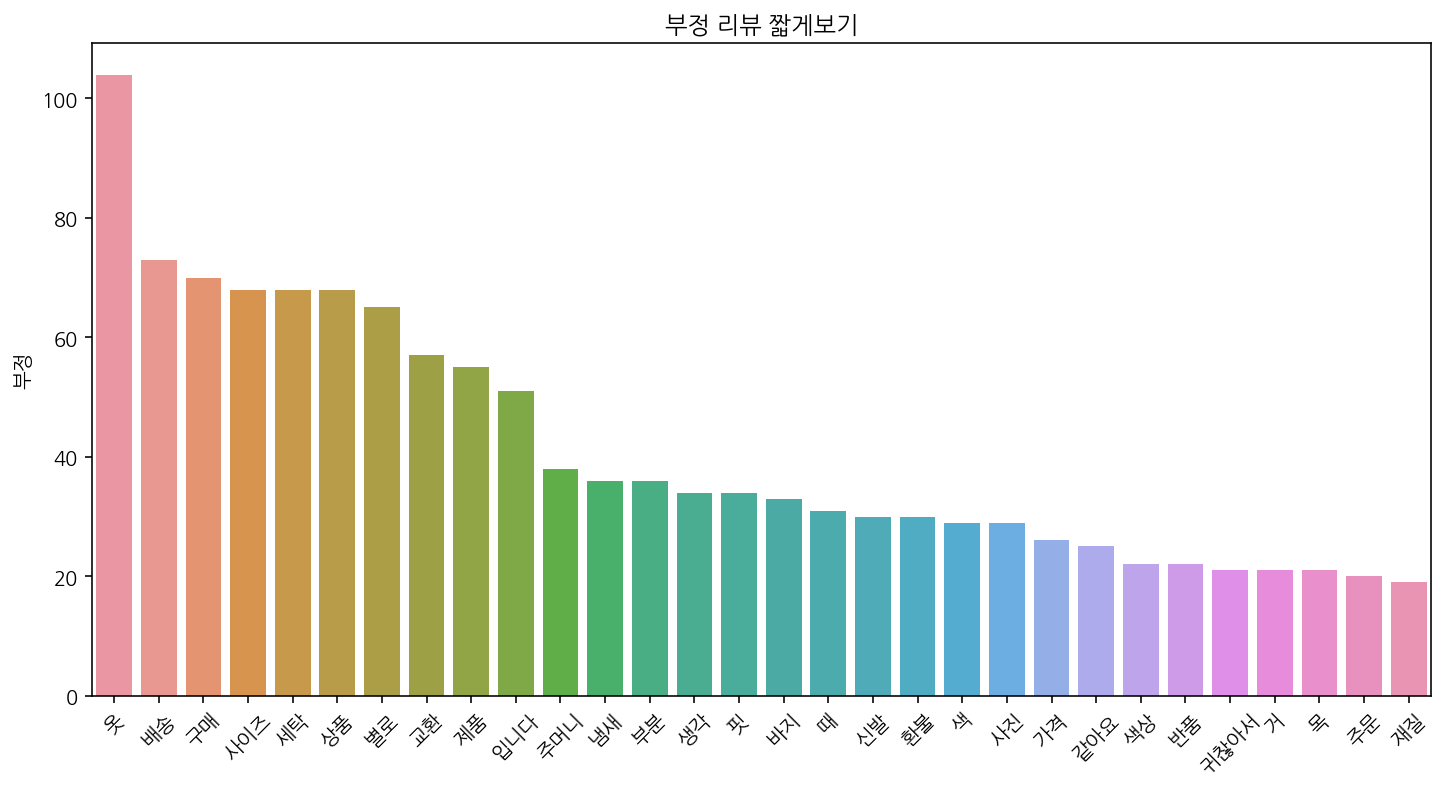

In [117]:
d = pd.DataFrame(real_neg)
d.columns = ['부정']

neg_top30 = d['부정'].value_counts().sort_values(ascending=False)[:30]
neg_top30 = pd.DataFrame(neg_top30)

plt.figure(figsize=(12,6))
_=sns.barplot(x=neg_top30.index, y=neg_top30['부정'])
_=plt.xticks(rotation=45)
_=plt.title('부정 리뷰 짧게보기')